<a href="https://colab.research.google.com/github/thunderhoser/ai2es_xai_course/blob/main/lecture01_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 1: Introduction to AI and explainable AI; *J*-measure; permutation test

This notebook was used for the AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence) in May-June 2021.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2021: "Lecture 1: Introduction to AI and XAI; *J*-measure; permutation test". AI2ES (NSF Institute for Research on Trustworthy Artificial Intelligence in Weather, Climate, and Coastal Oceanography) short course on XAI (explainable artificial intelligence), https://github.com/thunderhoser/ai2es_xai_course/.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Breiman, L., 2001: "Random forests." *Machine Learning*, **45**, 5–32, https://doi.org/10.1023/A:1010933404324.

Lagerquist, R., 2020: "Using deep learning to improve prediction and understanding of high-impact weather." Doctoral dissertation, University of Oklahoma, School of Meteorology, https://shareok.org/handle/11244/324145.

Lakshmanan, V., C. Karstens, J. Krause, K. Elmore, A. Ryzhkov, and S. Berkseth, 2015: "Which polarimetric variables are important for weather/no-weather discrimination?" *Journal of Atmospheric and Oceanic Technology*, **32**, 1209-1223, https://doi.org/10.1175/JTECH-D-13-00205.1.

McGovern, A., R. Lagerquist, D. Gagne, G. Jergensen, K. Elmore, C. Homeyer, and T. Smith, 2019: "Making the black box more transparent: Understanding the physical implications of machine learning." *Bulletin of the American Meteorological Society*, **100 (11)**, 2175-2199, https://doi.org/10.1175/BAMS-D-18-0195.1.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [ ]:
import os
import shutil

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository
!cd course_repository; python setup.py install

Cloning into 'course_repository'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 43 (delta 10), reused 35 (delta 6), pack-reused 0
Unpacking objects: 100% (43/43), done.
running install
running bdist_egg
running egg_info
creating ai2es_xai_course.egg-info
writing ai2es_xai_course.egg-info/PKG-INFO
writing dependency_links to ai2es_xai_course.egg-info/dependency_links.txt
writing requirements to ai2es_xai_course.egg-info/requires.txt
writing top-level names to ai2es_xai_course.egg-info/top_level.txt
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
writing manifest file 'ai2es_xai_course.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/ai2es_xai_course
copying ai2es_xai_course/__init__.py -> buil

# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [ ]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ai2es_xai_course/')
sys.path.append('/content/course_repository/ai2es_xai_course/utils/')

In [ ]:
%matplotlib inline
import copy
import os.path
import warnings
import numpy
import keras
from matplotlib import pyplot
import tensorflow.compat.v1 as tf
from ai2es_xai_course.utils import utils
from ai2es_xai_course.plotting import permutation_plotting

tf.disable_v2_behavior()
warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATA_DIRECTORY_NAME = '/content/data/track_data_ncar_ams_3km_csv_small'

Instructions for updating:
non-resource variables are not supported in the long term


# <font color='red'>Prevent auto-scrolling (required)</font>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [ ]:
!python /content/course_repository/download_tabular_data.py

Unzipping file: "data/track_data_ncar_ams_3km_csv_small.tar.gz"...


# <font color='red'>Read input data (required)</font>

The next cell reads all input data for this notebook into memory.

In [ ]:
training_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20100101',
    last_date_string='20141231'
)
validation_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20150101',
    last_date_string='20151231'
)
testing_file_names = utils.find_tabular_files(
    directory_name=DATA_DIRECTORY_NAME, first_date_string='20160101',
    last_date_string='20171231'
)

(training_metadata_table, training_predictor_table_denorm,
 training_target_table
) = utils.read_many_tabular_files(training_file_names)
print(MINOR_SEPARATOR_STRING)

(validation_metadata_table, validation_predictor_table_denorm,
 validation_target_table
) = utils.read_many_tabular_files(validation_file_names)
print(MINOR_SEPARATOR_STRING)

(testing_metadata_table, testing_predictor_table_denorm,
 testing_target_table
) = utils.read_many_tabular_files(testing_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in metadata are as follows:\n{0:s}'.format(
    str(list(training_metadata_table))
))

print('\nPredictor variables are as follows:\n{0:s}'.format(
    str(list(training_predictor_table_denorm))
))

print('\nTarget variable is as follows:\n{0:s}'.format(
    str(list(training_target_table))
))

first_predictor_name = list(training_predictor_table_denorm)[0]
these_predictor_values = (
    training_predictor_table_denorm[first_predictor_name].values[:10]
)

message_string = (
    '\nValues of predictor variable "{0:s}" for the first training '
    'examples:\n{1:s}'
).format(first_predictor_name, str(these_predictor_values))
print(message_string)

target_name = list(training_target_table)[0]
these_target_values = training_target_table[target_name].values[:10]

message_string = (
    '\nValues of target variable for the first training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# <font color='red'>Normalization (required)</font>

The next cell does the following:

 - Finds normalization parameters (mean and standard deviation) for each predictor, based only on the training data.
 - Normalizes the training, validation, and testing data.
 - Denormalizes the training data and ensures that denormalized values = original values (sanity check).

In [ ]:
predictor_names = list(training_predictor_table_denorm)
these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    'Original values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table, normalization_dict = utils.normalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table_denorm)
)

these_predictor_values = (
    training_predictor_table[predictor_names[0]].values[:10]
)

message_string = (
    '\nNormalized values of "{0:s}" for the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

training_predictor_table_denorm = utils.denormalize_predictors(
    predictor_table=copy.deepcopy(training_predictor_table),
    normalization_dict=normalization_dict
)

these_predictor_values = (
    training_predictor_table_denorm[predictor_names[0]].values[:10]
)

message_string = (
    '\n*De*normalized values (should equal original values) of "{0:s}" for '
    'the first training examples:\n{1:s}'
).format(predictor_names[0], str(these_predictor_values))
print(message_string)

validation_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(validation_predictor_table_denorm),
    normalization_dict=normalization_dict
)

testing_predictor_table, _ = utils.normalize_predictors(
    predictor_table=copy.deepcopy(testing_predictor_table_denorm),
    normalization_dict=normalization_dict
)

Original values of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]

Normalized values of "composite_refl_mean_dbz" for the first training examples:
[-1.03619508  0.06182963 -0.32830456 -0.63672124 -0.55287024 -0.62955524
 -0.27959332 -0.79199632 -0.36799241  0.11659495]

*De*normalized values (should equal original values) of "composite_refl_mean_dbz" for the first training examples:
[42.71822 47.09285 45.53852 44.30976 44.64383 44.33831 45.73259 43.69113
 45.3804  47.31104]


# <font color='red'>Binarize target variable (required)</font>

- The next cell binarizes the target variable (max future vorticity in s$^{-1}$).
- **Binarization turns each value into a 0 (no) or 1 (yes), based on whether or not future vorticity reaches a threshold.**
- This is necessary because the neural network used in this notebook does classification, not regression.
- However, neural networks *can* do regression as well.

In [ ]:
binarization_threshold = utils.get_binarization_threshold(
    tabular_file_names=training_file_names, percentile_level=90.
)
print(MINOR_SEPARATOR_STRING)

these_target_values = (
    training_target_table[utils.TARGET_NAME].values[1030:1050]
)

message_string = (
    'Real-numbered target values for a few training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

training_target_values = utils.binarize_target_values(
    target_values=training_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
training_target_table = training_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: training_target_values}
)

print('\nBinarization threshold = {0:.3e} s^-1'.format(
    binarization_threshold
))

these_target_values = (
    training_target_table[utils.BINARIZED_TARGET_NAME].values[1030:1050]
)

message_string = (
    '\nBinarized target values for the same training examples:\n{0:s}'
).format(str(these_target_values))
print(message_string)

validation_target_values = utils.binarize_target_values(
    target_values=validation_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
validation_target_table = validation_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: validation_target_values}
)

testing_target_values = utils.binarize_target_values(
    target_values=testing_target_table[utils.TARGET_NAME].values,
    binarization_threshold=binarization_threshold
)
testing_target_table = testing_target_table.assign(
    **{utils.BINARIZED_TARGET_NAME: testing_target_values}
)

Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101024-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20101122-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110201-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110308-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110326-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110404-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110414-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_NCARSTORM_d01_20110420-0000.csv"...
Reading data from: "/content/data/track_data_ncar_ams_3km_csv_small/track_step_N

# <font color='red'>Read pre-trained neural network (required)</font>

The next cell reads a pre-trained neural network, to which explanation methods (the $J$-measure and permutation importance test) will be applied.

In [ ]:
pretrained_model_file_name = (
    '/content/course_repository/dense_net_for_interpretation/model.h5'
)

pretrained_model_object = utils.read_dense_net(pretrained_model_file_name)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Permutation importance test (PIT): Theory

 - **The PIT measures the importance of each predictor variable, averaged over all examples in a dataset.**
   - We apply the PIT (and all other explanation methods) to the testing set, to ensure that results are not influenced by overfitting the training or validation sets.
   - However, some people apply explanation methods to the training and validation sets as well.
   - There is some debate over which dataset is most appropriate.
<br><br>

 - **The "importance" of predictor $x_j$ is determined by how much model performance declines when $x_j$ is permuted** (values of $x_j$ are assigned to random examples).
 - If performance declines significantly, $x_j$ is important.
 - If performance does not decline significantly, $x_j$ is either unimportant or highly correlated with other predictors.
<br><br>

 - **The PIT can be applied to any AI model,** not just neural networks.
 - **There are four versions of the PIT (see below).**
 - The four versions handle correlated predictors in different ways.
 - It is often beneficial to run all four versions and compare the results.

## Single-pass forward test

Let:

 - $F$ be the trained model
 - $\mathbf{X}$ be the clean dataset (with no predictors permuted)
<br><br>

1. Repeat the following for each predictor $x_j$:<br>
  a. Copy the dataset $\mathbf{X}$ to a new variable, $\mathbf{X}'$.<br>
  b. Permute values of $x_j$ over all examples in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Rank predictors by loss after permutation.<br>
   In other words, the most important predictor is that whose permutation causes the highest loss.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is that whose permutation causes the $k^{\textrm{th}}$-highest loss.
<br><br>

For more details, see Breiman (2001).

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/forward_single_pass_test.gif" width="500"></center>
<center>(Adapted from Supplementary Figure ES5 of McGovern et al. 2019)</center>

## Multi-pass forward test

Let:

 - $F$ be the trained model
 - $\mathbf{X}$ be the clean dataset (with no predictors permuted)
 - $U$ be the set of predictors that are still clean (not yet permuted)
<br><br>

1. Repeat the following for each predictor $x_j \in U$:<br>
  a. Copy the dataset $\mathbf{X}$ to a new variable, $\mathbf{X}'$.<br>
  b. Permute values of $x_j$ over all examples in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Find the predictor whose permutation led to the highest loss in step 1.  This is the most important predictor still in $U$.  Call this predictor $x^*$.<br>
3. Remove $x^*$ from $U$ and permanently permute $x^*$ in dataset $\mathbf{X}$.
<br>
4. Repeat steps 1-3 until $U$ is empty (all predictors are permuted in $\mathbf{X}$).
<br>
5. Rank predictors by order in which they were permanently permuted (in $\mathbf{X}$, not $\mathbf{X}'$).<br>
   In other words, the most important predictor is the first to be permanently permuted.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is the $k^{\textrm{th}}$ to be permanently permuted.
<br><br>

For more details, see Lakshmanan *et al.* (2015).

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/forward_multi_pass_test.gif" width="500"></center>
<center>(Adapted from Supplementary Figure ES6 of McGovern et al. 2019)</center>

## Single-pass backwards test

Let:

 - $F$ be the trained model
 - $\mathbf{X}_{\textrm{dirty}}$ be the dirty dataset (with all predictors permuted)
<br><br>

1. Repeat the following for each predictor $x_j$:<br>
  a. Copy the dataset $\mathbf{X}_{\textrm{dirty}}$ to a new variable, $\mathbf{X}'$.<br>
  b. Restore values of $x_j$ to their correct order in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Rank predictors by loss after restoration.<br>
   In other words, the most important predictor is that whose restoration causes the lowest loss.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is that whose restoration causes the $k^{\textrm{th}}$-lowest loss.

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/backwards_single_pass_test.gif" width="500"></center>

## Multi-pass backwards test

Let:

 - $F$ be the trained model
 - $\mathbf{X}$ be the dirty dataset (with all predictors permuted)
 - $U$ be the set of predictors that are still dirty (not yet restored)
<br><br>

1. Repeat the following for each predictor $x_j \in U$:<br>
  a. Copy the dataset $\mathbf{X}$ to a new variable, $\mathbf{X}'$.<br>
  b. Restore values of $x_j$ to their correct order in $\mathbf{X}'$.<br>
  c. Pass $\mathbf{X}'$ through $F$ and record the new loss.<br><br>
2. Find the predictor whose restoration led to the lowest loss in step 1.  This is the most important predictor still in $U$.  Call this predictor $x^*$.<br>
3. Remove $x^*$ from $U$ and permanently restore $x^*$ in dataset $\mathbf{X}$.
<br>
4. Repeat steps 1-3 until $U$ is empty (all predictors are restored in $\mathbf{X}$).
<br>
5. Rank predictors by order in which they were permanently restored (in $\mathbf{X}$, not $\mathbf{X}'$).<br>
   In other words, the most important predictor is the first to be permanently restored.<br>
   More generally, the $k^{\textrm{th}}$-most important predictor is the $k^{\textrm{th}}$ to be permanently restored.

<center><img src="https://raw.githubusercontent.com/thunderhoser/cira_ml_short_course/master/backwards_multi_pass_test.gif" width="500"></center>

## Correlated predictors

- The four versions of the test handle correlated predictors differently.
- **The discussion below also appears in 7.1.1 of Lagerquist (2020).**
<br><br>

- **Suppose that:**
  - $x_n = 2x_m$, where $x_m$ and $x_n$ are two predictors.
  - Thus, $x_m$ and $x_n$ are completely redundant (correlation of 1.0) and should have nearly identical effects on the trained model.
  - $x_m$ and $x_n$ are highly important and not correlated with other predictors.
<br><br>

- **Single-pass forward test:** neither $x_m$ nor $x_n$ will be considered important, because permuting one and not the other has a minimal effect on model performance.
- **Single-pass backward test:** both $x_m$ and $x_n$ will be considered important, because cleaning either one substantially improves model performance, even while the other is still permuted.
- **Multi-pass forward test:**
  - Once $x_m$ has been permanently permuted (assuming that $x_m$ is permanently permuted before $x_n$), the most important predictor remaining should be $x_n$, since the dataset no longer contains info redundant with $x_m$.
  - However, $x_m$ is not permanently permuted until late in the algorithm (because $x_n$ contains the same info), so neither $x_m$ nor $x_n$ is considered important.

- **Multi-pass backward test:**
  - Once $x_m$ has been permanently cleaned (assuming that $x_m$ is permanently cleaned before $x_n$), $x_n$ is considered unimportant, since the dataset contains info redundant with $x_m$.
  - $x_m$ is permanently cleaned early in the algorithm, so $x_m$ is considered highly important and $x_n$ is considered unimportant.

# Permutation importance test (PIT): Code

## Run forward versions of test

 - The next cell runs both forward versions (single-pass and multi-pass) of the permutation importance test.
 - **The loss function is negative AUC (area under ROC curve).**
 - At each step, the code computes a 95% confidence interval for the loss, using 1000 bootstrap replicates.
 - **In each figure, the most (least) important predictor is at the top (bottom)**.
<br><br>

 - To save computing time, we use only the first 2000 testing examples.
 - To declutter the figures, we plot only the 20 (out of 41) most important predictors.

In [ ]:
testing_classes = testing_target_table[utils.BINARIZED_TARGET_NAME].values
negative_indices = numpy.where(testing_classes == 0)[0][:1000]
positive_indices = numpy.where(testing_classes == 1)[0][:1000]
example_indices = numpy.concatenate((negative_indices, positive_indices))

numpy.random.shuffle(example_indices)

small_testing_predictor_table = testing_predictor_table.iloc[example_indices]
small_testing_target_table = testing_target_table.iloc[example_indices]

forward_result_dict = utils.run_forward_test(
    predictor_matrix=small_testing_predictor_table.to_numpy(),
    predictor_names=list(small_testing_predictor_table),
    target_classes=
    small_testing_target_table[utils.BINARIZED_TARGET_NAME].values,
    model_object=pretrained_model_object
)

Finding original cost (before permutation)...
Average cost estimate over 1000 replicates = -0.945036


--------------------------------------------------


Permuting 1th of 41 predictors...
Average cost estimate over 1000 replicates = -0.941563
Permuting 2th of 41 predictors...
Average cost estimate over 1000 replicates = -0.934520
Permuting 3th of 41 predictors...
Average cost estimate over 1000 replicates = -0.944989
Permuting 4th of 41 predictors...
Average cost estimate over 1000 replicates = -0.943972
Permuting 5th of 41 predictors...
Average cost estimate over 1000 replicates = -0.941948
Permuting 6th of 41 predictors...
Average cost estimate over 1000 replicates = -0.940557
Permuting 7th of 41 predictors...
Average cost estimate over 1000 replicates = -0.943796
Permuting 8th of 41 predictors...
Average cost estimate over 1000 replicates = -0.943161
Permuting 9th of 41 predictors...
Average cost estimate over 1000 replicates = -0.942056
Permuting 10th of 41 predictors...
Average 

## Plot results

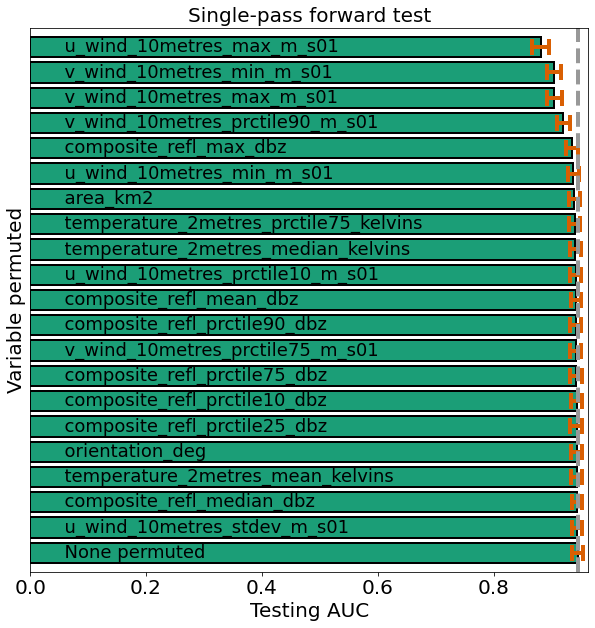

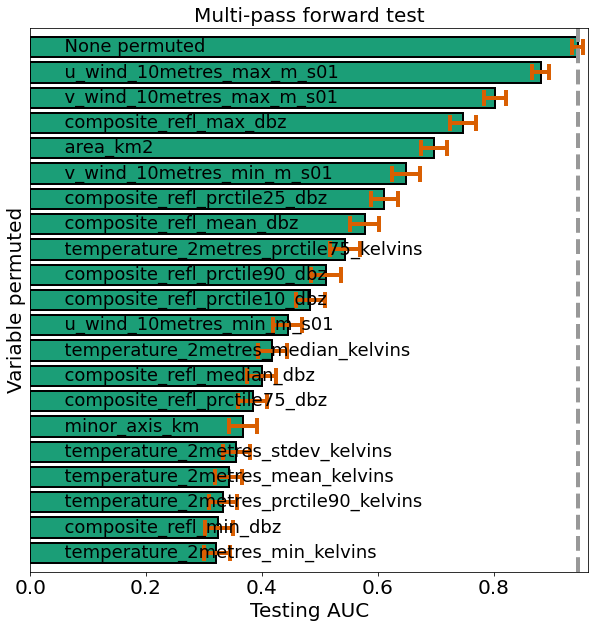

In [ ]:
axes_object = permutation_plotting.plot_single_pass_test(
    result_dict=forward_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Single-pass forward test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()
print('\n\n')

axes_object = permutation_plotting.plot_multipass_test(
    result_dict=forward_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Multi-pass forward test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()

## Run backwards versions of test

 - The next cell runs both backwards versions (single-pass and multi-pass) of the permutation importance test.
 - **In each figure, the most (least) important predictor is at the top (bottom)**.

In [ ]:
testing_classes = testing_target_table[utils.BINARIZED_TARGET_NAME].values
negative_indices = numpy.where(testing_classes == 0)[0][:1000]
positive_indices = numpy.where(testing_classes == 1)[0][:1000]
example_indices = numpy.concatenate((negative_indices, positive_indices))

numpy.random.shuffle(example_indices)

small_testing_predictor_table = testing_predictor_table.iloc[example_indices]
small_testing_target_table = testing_target_table.iloc[example_indices]

backwards_result_dict = utils.run_backwards_test(
    predictor_matrix=small_testing_predictor_table.to_numpy(),
    predictor_names=list(small_testing_predictor_table),
    target_classes=
    small_testing_target_table[utils.BINARIZED_TARGET_NAME].values,
    model_object=pretrained_model_object
)

Finding cost on clean data (before permutation)...
Average cost estimate over 1000 replicates = -0.931211
Finding cost on dirty data (before *de*permutation)...
Average cost estimate over 1000 replicates = -0.557967


--------------------------------------------------


Depermuting 1th of 41 predictors...
Average cost estimate over 1000 replicates = -0.583243
Depermuting 2th of 41 predictors...
Average cost estimate over 1000 replicates = -0.616347
Depermuting 3th of 41 predictors...
Average cost estimate over 1000 replicates = -0.558694
Depermuting 4th of 41 predictors...
Average cost estimate over 1000 replicates = -0.529598
Depermuting 5th of 41 predictors...
Average cost estimate over 1000 replicates = -0.571950
Depermuting 6th of 41 predictors...
Average cost estimate over 1000 replicates = -0.578529
Depermuting 7th of 41 predictors...
Average cost estimate over 1000 replicates = -0.575823
Depermuting 8th of 41 predictors...
Average cost estimate over 1000 replicates = -0.570057
D

## Plot results

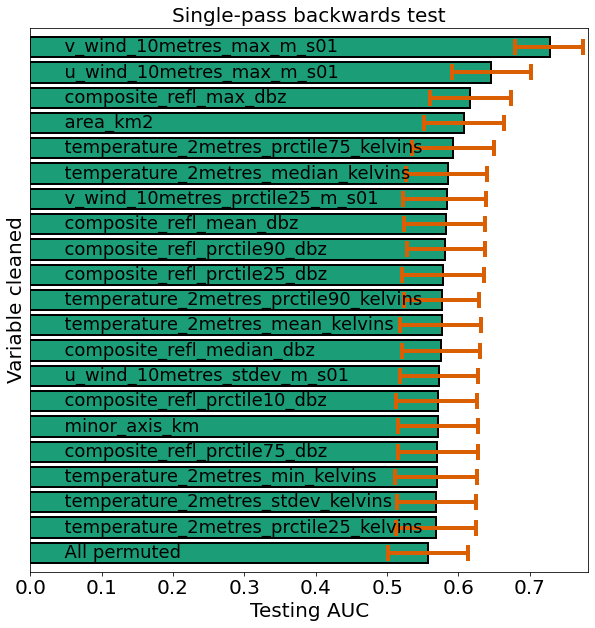

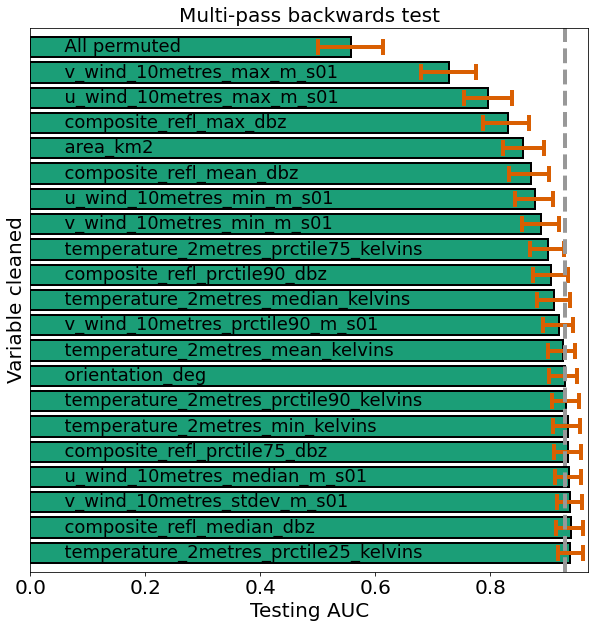

In [ ]:
axes_object = permutation_plotting.plot_single_pass_test(
    result_dict=backwards_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Single-pass backwards test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()
print('\n\n')

axes_object = permutation_plotting.plot_multipass_test(
    result_dict=backwards_result_dict, num_predictors_to_plot=20
)
axes_object.set_title('Multi-pass backwards test')
axes_object.set_xlabel('Testing AUC')
pyplot.show()

# $J$-measure: Theory

- The $J$-measure is a model-independent explanation method for binary classification.
- Specifically, it is the Kullback-Leibler divergence between the probability distributions $p(x_j \mid y = 0)$ and $p(x_j \mid y = 1)$.
- $p(x_j \mid y = 0)$ is the distribution of predictor $x_j$ for negative cases (here, storms without strong future vorticity).
- $p(x_j \mid y = 1)$ is the distribution of predictor $x_j$ for positive cases (here, storms with strong future vorticity).
<br><br>

Discretizing $x_j$ into $K$ bins, the $J$-measure is as follows:

$J(x_j) = \sum\limits_{k = 1}^{K} \bigg[ p(x_j \in X_{jk} \mid y = 0) - p(x_j \in X_{jk} \mid y = 1) \bigg]\textrm{ log}_2 \bigg\lbrace \frac{p(x_j \in X_{jk} \mid y = 0)}{p(x_j \in X_{jk} \mid y = 1)} \bigg\rbrace$
<br><br>

**If the two distributions have no overlap:**
 - $x_j$ is a perfect discriminator.
 - The $J$-measure is large (maybe infinite).
<br><br>

**If the two distributions are identical:**
 - $x_j$ is a useless discriminator.
 - The $J$-measure is 0.

# $J$-measure: Code

## Run

The next cell computes the *J*-measure for each predictor variable, using unnormalized values from all three datasets (training, validation, and testing).

In [ ]:
training_classes = training_target_table[utils.BINARIZED_TARGET_NAME].values
negative_training_indices = numpy.where(training_classes == 0)[0]
positive_training_indices = numpy.where(training_classes == 1)[0]

validation_classes = validation_target_table[utils.BINARIZED_TARGET_NAME].values
negative_validation_indices = numpy.where(validation_classes == 0)[0]
positive_validation_indices = numpy.where(validation_classes == 1)[0]

testing_classes = testing_target_table[utils.BINARIZED_TARGET_NAME].values
negative_testing_indices = numpy.where(testing_classes == 0)[0]
positive_testing_indices = numpy.where(testing_classes == 1)[0]

predictor_names = list(training_predictor_table_denorm)
j_measures = [''] * len(predictor_names)

for j in range(len(predictor_names)):
    this_name = predictor_names[j]

    predictor_values_negative = numpy.concatenate((
        training_predictor_table_denorm[this_name].values[negative_training_indices],
        validation_predictor_table_denorm[this_name].values[negative_validation_indices],
        testing_predictor_table_denorm[this_name].values[negative_testing_indices]
    ))

    predictor_values_positive = numpy.concatenate((
        training_predictor_table_denorm[this_name].values[positive_training_indices],
        validation_predictor_table_denorm[this_name].values[positive_validation_indices],
        testing_predictor_table_denorm[this_name].values[positive_testing_indices]
    ))

    j_measures[j] = utils.get_j_measure(
        predictor_values_positive=predictor_values_positive,
        predictor_values_negative=predictor_values_negative,
        max_percentile_level=99.5, num_bins=100, min_examples_per_bin=10
    )

    print('J-measure for {0:s} = {1:.4f}'.format(this_name, j_measures[j]))

J-measure for composite_refl_mean_dbz = 2.4796
J-measure for composite_refl_max_dbz = 2.9989
J-measure for composite_refl_min_dbz = 0.4083
J-measure for composite_refl_stdev_dbz = 1.9027
J-measure for composite_refl_prctile10_dbz = 1.3319
J-measure for composite_refl_prctile25_dbz = 1.7679
J-measure for composite_refl_median_dbz = 2.1503
J-measure for composite_refl_prctile75_dbz = 2.4390
J-measure for composite_refl_prctile90_dbz = 2.6600
J-measure for u_wind_10metres_mean_m_s01 = 0.0276
J-measure for u_wind_10metres_max_m_s01 = 0.8709
J-measure for u_wind_10metres_min_m_s01 = 0.6248
J-measure for u_wind_10metres_stdev_m_s01 = 2.2371
J-measure for u_wind_10metres_prctile10_m_s01 = 0.2118
J-measure for u_wind_10metres_prctile25_m_s01 = 0.0606
J-measure for u_wind_10metres_median_m_s01 = 0.0243
J-measure for u_wind_10metres_prctile75_m_s01 = 0.1386
J-measure for u_wind_10metres_prctile90_m_s01 = 0.3693
J-measure for v_wind_10metres_mean_m_s01 = 0.0397
J-measure for v_wind_10metres_max_m

## Plot results

The next cell plots results.

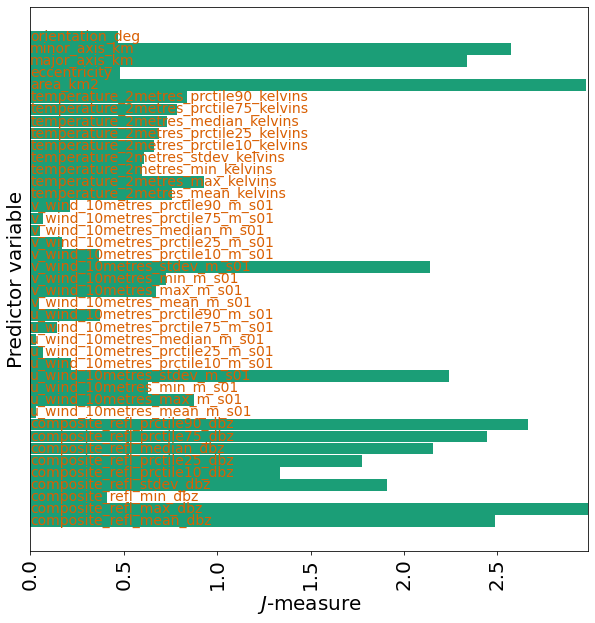

In [ ]:
utils.plot_j_measures(j_measures=j_measures, predictor_names=predictor_names)
pyplot.show()

# Partial-dependence plots (PDP): Code

Applying neural net to data with area_km2 = 36...
Applying neural net to data with area_km2 = 36...
Applying neural net to data with area_km2 = 36...
Applying neural net to data with area_km2 = 36...
Applying neural net to data with area_km2 = 36...
Applying neural net to data with area_km2 = 45...
Applying neural net to data with area_km2 = 45...
Applying neural net to data with area_km2 = 45...
Applying neural net to data with area_km2 = 54...
Applying neural net to data with area_km2 = 54...
Applying neural net to data with area_km2 = 54...
Applying neural net to data with area_km2 = 63...
Applying neural net to data with area_km2 = 63...
Applying neural net to data with area_km2 = 63...
Applying neural net to data with area_km2 = 72...
Applying neural net to data with area_km2 = 72...
Applying neural net to data with area_km2 = 72...
Applying neural net to data with area_km2 = 81...
Applying neural net to data with area_km2 = 81...
Applying neural net to data with area_km2 = 81...


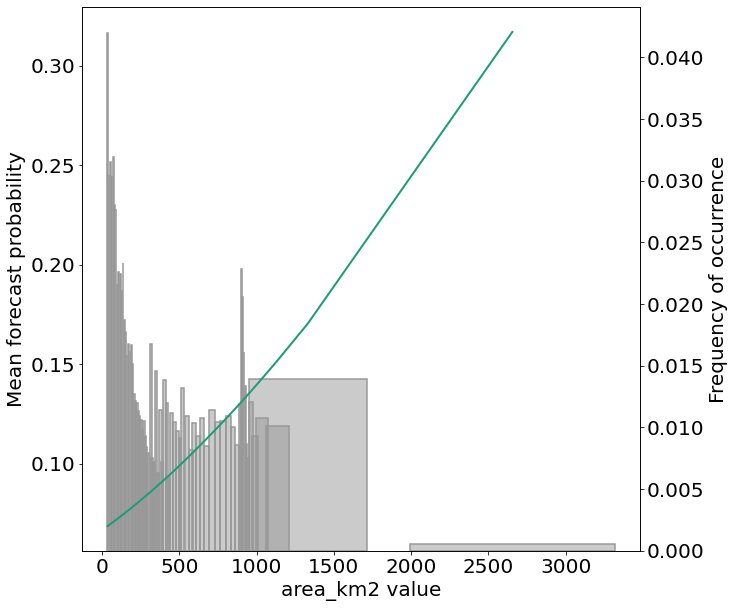

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='area_km2', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='area_km2', trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with composite_refl_max_dbz = 40...
Applying neural net to data with composite_refl_max_dbz = 42...
Applying neural net to data with composite_refl_max_dbz = 42...
Applying neural net to data with composite_refl_max_dbz = 43...
Applying neural net to data with composite_refl_max_dbz = 43...
Applying neural net to data with composite_refl_max_dbz = 43...
Applying neural net to data with composite_refl_max_dbz = 44...
Applying neural net to data with composite_refl_max_dbz = 44...
Applying neural net to data with composite_refl_max_dbz = 44...
Applying neural net to data with composite_refl_max_dbz = 44...
Applying neural net to data with composite_refl_max_dbz = 45...
Applying neural net to data with composite_refl_max_dbz = 45...
Applying neural net to data with composite_refl_max_dbz = 45...
Applying neural net to data with composite_refl_max_dbz = 45...
Applying neural net to data with composite_refl_max_dbz = 45...
Applying neural net to data with composi

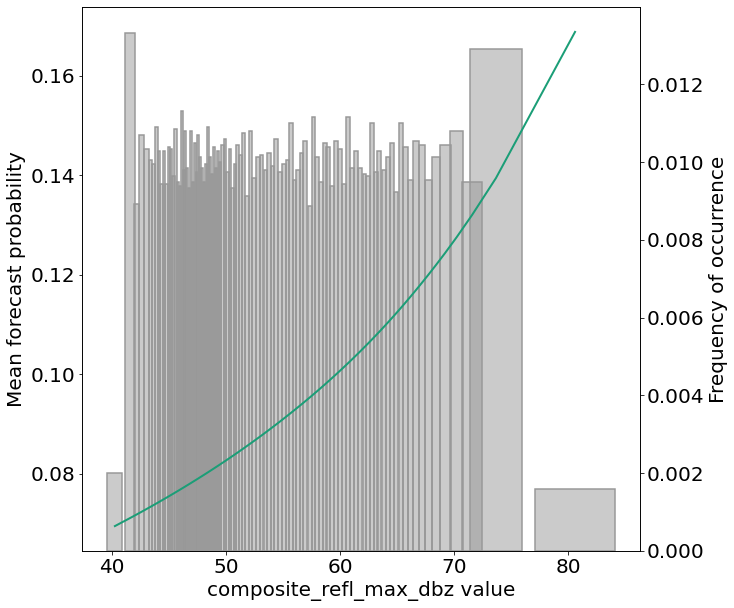

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='composite_refl_max_dbz', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='composite_refl_max_dbz',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with composite_refl_mean_dbz = 40...
Applying neural net to data with composite_refl_mean_dbz = 41...
Applying neural net to data with composite_refl_mean_dbz = 41...
Applying neural net to data with composite_refl_mean_dbz = 41...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 42...
Applying neural net to data with composite_refl_mean_dbz = 43...
Applying neural net to data with composite_refl_mean_dbz = 43...
Applying neural net to data with composite_refl_mean_dbz = 43...
Applying neural net to da

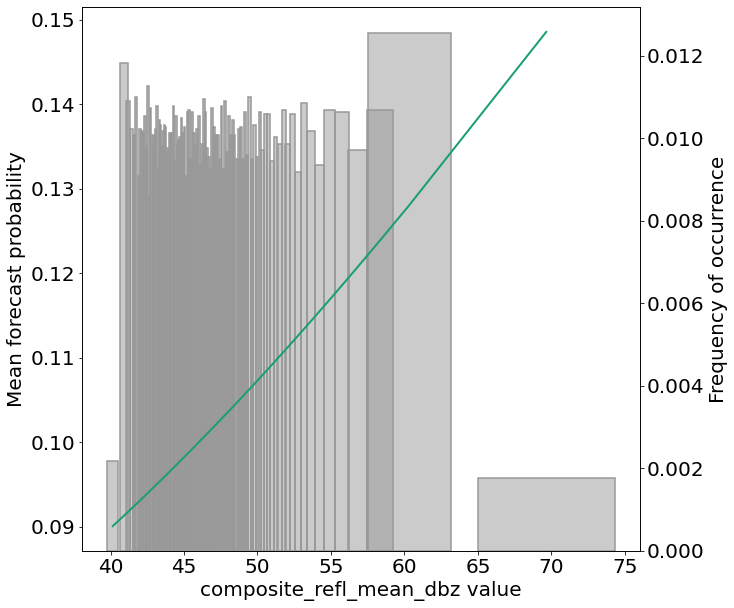

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='composite_refl_mean_dbz', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='composite_refl_mean_dbz',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with composite_refl_stdev_dbz = 0.051...
Applying neural net to data with composite_refl_stdev_dbz = 0.29...
Applying neural net to data with composite_refl_stdev_dbz = 0.39...
Applying neural net to data with composite_refl_stdev_dbz = 0.49...
Applying neural net to data with composite_refl_stdev_dbz = 0.57...
Applying neural net to data with composite_refl_stdev_dbz = 0.65...
Applying neural net to data with composite_refl_stdev_dbz = 0.72...
Applying neural net to data with composite_refl_stdev_dbz = 0.8...
Applying neural net to data with composite_refl_stdev_dbz = 0.86...
Applying neural net to data with composite_refl_stdev_dbz = 0.92...
Applying neural net to data with composite_refl_stdev_dbz = 0.97...
Applying neural net to data with composite_refl_stdev_dbz = 1...
Applying neural net to data with composite_refl_stdev_dbz = 1.1...
Applying neural net to data with composite_refl_stdev_dbz = 1.1...
Applying neural net to data with composite_refl_stdev

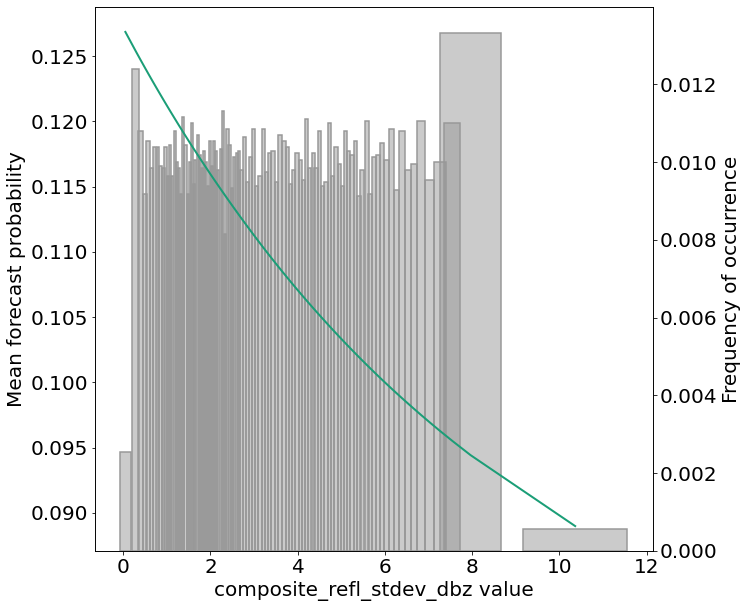

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='composite_refl_stdev_dbz', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='composite_refl_stdev_dbz',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.014...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.13...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.18...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.22...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.26...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.29...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.31...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.34...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.37...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.4...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.42...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.45...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.47...
Applying neural net to data with v_wind_10metres_stdev_m_s01 = 0.5...
Applyin

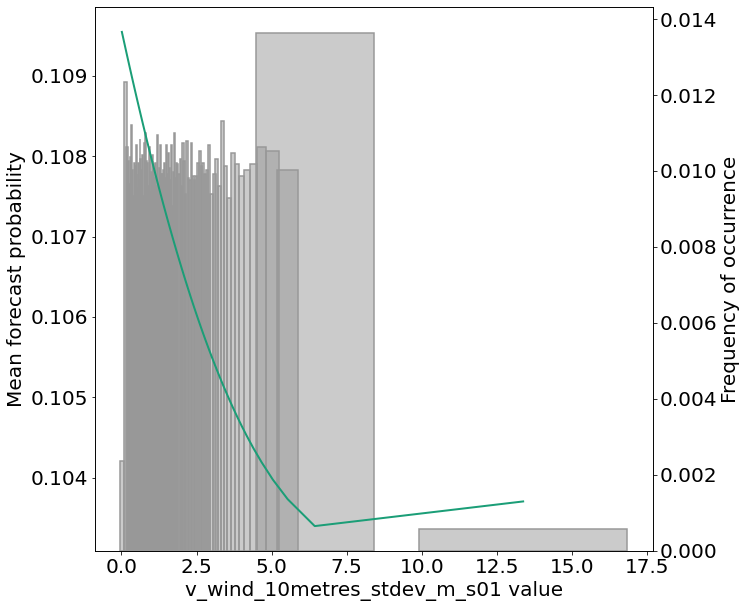

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='v_wind_10metres_stdev_m_s01', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='v_wind_10metres_stdev_m_s01',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.0037...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.13...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.17...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.21...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.24...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.27...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.3...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.33...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.36...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.39...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.41...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.44...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.46...
Applying neural net to data with u_wind_10metres_stdev_m_s01 = 0.49...
Apply

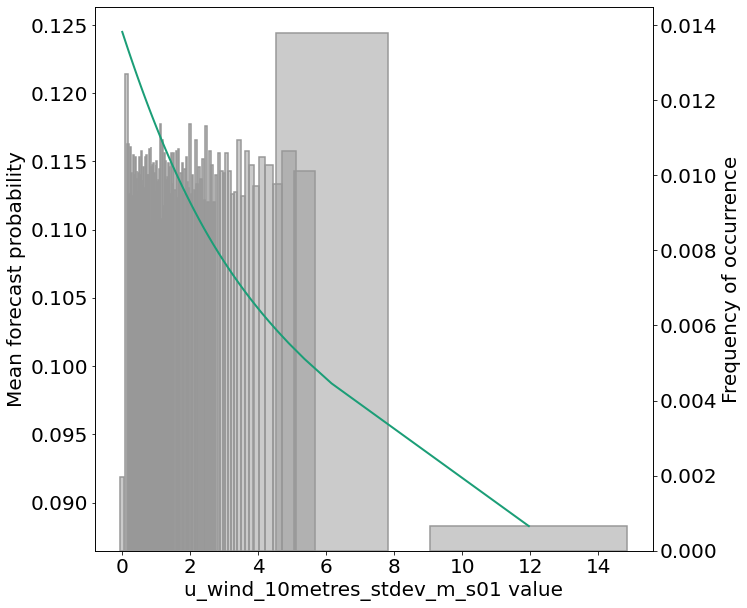

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='u_wind_10metres_stdev_m_s01', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='u_wind_10metres_stdev_m_s01',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with orientation_deg = -90...
Applying neural net to data with orientation_deg = -90...
Applying neural net to data with orientation_deg = -90...
Applying neural net to data with orientation_deg = -90...
Applying neural net to data with orientation_deg = -87...
Applying neural net to data with orientation_deg = -84...
Applying neural net to data with orientation_deg = -82...
Applying neural net to data with orientation_deg = -80...
Applying neural net to data with orientation_deg = -78...
Applying neural net to data with orientation_deg = -76...
Applying neural net to data with orientation_deg = -74...
Applying neural net to data with orientation_deg = -72...
Applying neural net to data with orientation_deg = -72...
Applying neural net to data with orientation_deg = -70...
Applying neural net to data with orientation_deg = -68...
Applying neural net to data with orientation_deg = -66...
Applying neural net to data with orientation_deg = -64...
Applying neura

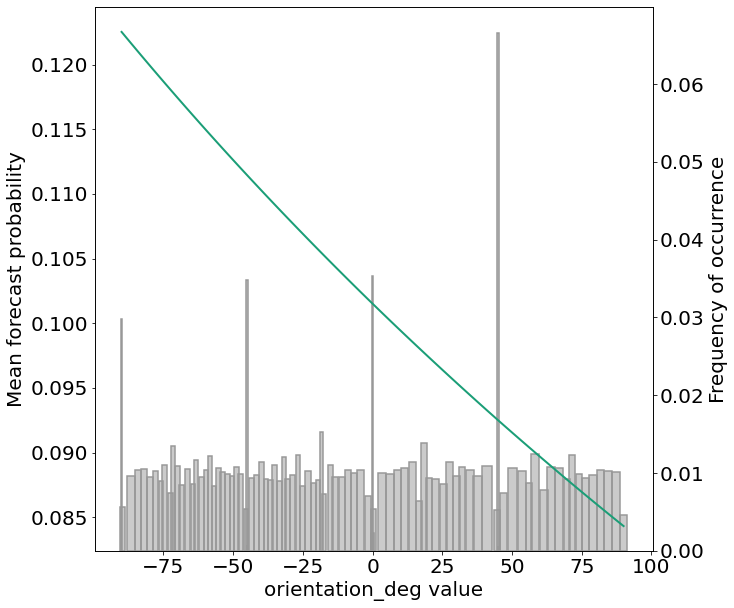

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='orientation_deg', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='orientation_deg',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with eccentricity = 0...
Applying neural net to data with eccentricity = 0...
Applying neural net to data with eccentricity = 0...
Applying neural net to data with eccentricity = 0...
Applying neural net to data with eccentricity = 0.2...
Applying neural net to data with eccentricity = 0.36...
Applying neural net to data with eccentricity = 0.38...
Applying neural net to data with eccentricity = 0.42...
Applying neural net to data with eccentricity = 0.47...
Applying neural net to data with eccentricity = 0.49...
Applying neural net to data with eccentricity = 0.51...
Applying neural net to data with eccentricity = 0.52...
Applying neural net to data with eccentricity = 0.54...
Applying neural net to data with eccentricity = 0.57...
Applying neural net to data with eccentricity = 0.58...
Applying neural net to data with eccentricity = 0.6...
Applying neural net to data with eccentricity = 0.61...
Applying neural net to data with eccentricity = 0.61...
Applyi

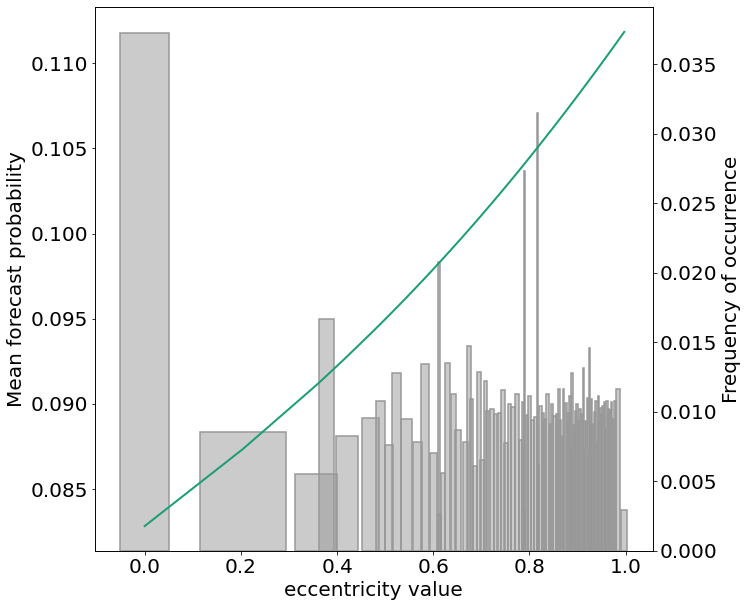

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='eccentricity', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='eccentricity',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)

Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.7e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.8e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.8e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.8e+02...
Applying neural net to data with temperature_2metres_min_kelvins = 2.8e+02...
Applying neural net to data with temperature_2metres_min_kelvins

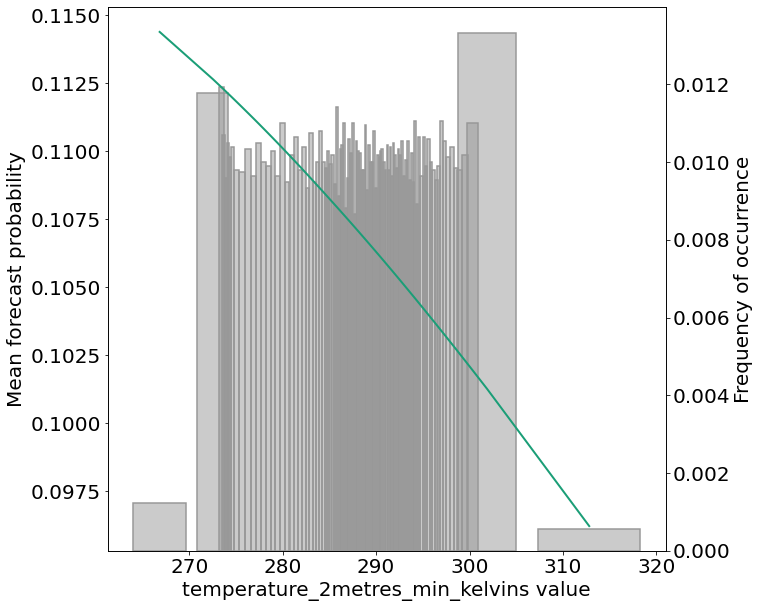

In [ ]:
trial_values_denorm, mean_probabilities, frequencies = utils.make_pdp_inputs(
    neural_net_object=pretrained_model_object,
    predictor_table_norm=testing_predictor_table,
    predictor_table_denorm=testing_predictor_table_denorm,
    normalization_dict=normalization_dict,
    trial_predictor_name='temperature_2metres_min_kelvins', num_trial_values=100
)

utils.plot_pdp(
    trial_predictor_name='temperature_2metres_min_kelvins',
    trial_values_denorm=trial_values_denorm,
    mean_probabilities=mean_probabilities, frequencies=frequencies
)